# CLAYTON BASS - Final Project - MATH 76
## Python Code Documentation for Final Project
My project tries to answer the question, "Are suicide rates decreasing over time in the United States from 1985 through 2015?" More specifically, with respect to the Bayesian inference problem I am solving, I ask the question, "What is the probability that the slope of the regression line fitted to the data from 1985 through 2015 is less than zero?" More detail on these questions and the formulation of, and solution to, my project can be found in the PDF write-up. This document serves to give a direct glance at the code used to perform my analysis and regression, along with some illustrative plots to be included in my Results section and critically analyzed and examined in my Discussion section found in my PDF write-up.

### NOTE: All citations and works cited are present in my official/main PDF write-up (in the final "Works Cited" section). The data in this analysis is sourced from the post by user Rusty (or russellyates88) on Kaggle at the following link: https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016/data#.  In particular, the source written by David Robinson (link: http://varianceexplained.org/r/empirical_bayes_baseball/) was integral in helping figure out the formulation of an empirical Bayesian estimation problem (which structures this entire analysis/problem formulation and solution). (With regard to the other two sources in my PDF write-up file: the source by Yifan Peng (link: http://blog.pengyifan.com/the-best-way-to-place-figures-side-by-side-in-latex/) was strictly for displaying images in my PDF write-up. Otherwise, the source by Holly Hedegaard, M.D., et al. (link: www.cdc.gov/nchs/products/databriefs/db362.htm) was used only in a comparison in my Discussion section in the main PDF write-up.)

### NOTE 2: The file "master.csv" has also been uploaded into the final GitHub repository, and this .csv file contains all of the data used in the analyses in this notebook and this project (this data comes from the download at https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016/data#).  

## First, we import and clean the data. This is based on the ExtentRegression.ipynb Jupyter Notebook file from Lecture 14 (in its code repository). 

### This first section will be for our empirical Bayes estimation where we use the entire dataset (per the aforementioned Robinson source). We aggregate over sex and age band, so that we simply have one "observation," or data point, for each year from 1985 through 2015 (although data are missing for some of these years). We tally the total suicide count for these years and divide by the total population, but then multiply by 100,000/100,000 to get the suicide rate per 100,000 people (which is an easily understandable metric). The rate would be very, very small if we considered only on an individual level. We accomplish this by examining anomalies: we examine the average suicide rate per 100,000 people from 1985 to 2000, and then calculate the anomaly (i.e., the observed value minus the sample average from 1985 to 2000) to determine the suicide rate anomaly for a given year.

#### My exact data source can be found at the following link: https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016?select=master.csv. 

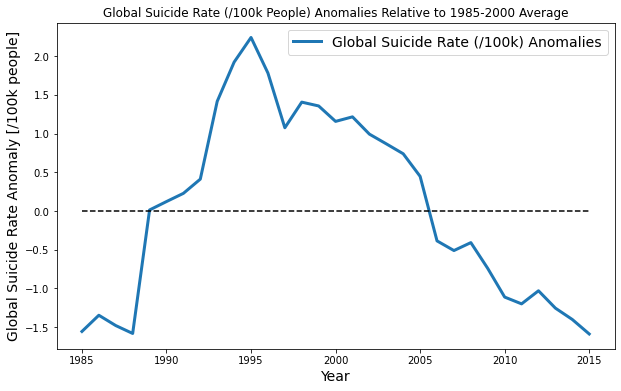

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymuqModeling as mm
import pymuqApproximationWrappers as ma
from scipy.stats import norm

#Read in the full dataset. 
total_df = pd.read_csv('master.csv')
new_df = total_df.iloc[:, 0:6]
year_start = 1985
year_end = 2015

#Create an array to store all suicide rates per 100k per year
# across the globe. Run a loop over the array to store each value
# properly. Also, create an array where we can store the average
# from 1985 through 2000. We will then create an anomaly array manually
# afterwawrds for all years from 1985 through 2015.
global_per_100k_array = [0]*(year_end-year_start+1)
rate_1985_2000_100k = np.array([0]*(2000-1985+1))

for year in range(1985, 2016):
    curr_df = new_df.loc[new_df['year'] == year, :]
    suicides_count = sum(curr_df.loc[:, 'suicides_no'])
    population_count = sum(curr_df.loc[:, 'population'])
    if year <= 2000:
        rate_1985_2000_100k[year - 1985] = 100000 * suicides_count / population_count
    rate_per_person = suicides_count/population_count
    rate_per_100k = rate_per_person * 100000
    global_per_100k_array[year - 1985] = rate_per_100k
    
#Calculate the mean number of suicides from 1985 to 2000,
# after which we normalize to a per-100,000 people scale.
# Note that some data are missing (i.e., some countries don't provide
# data for every year), but this is adjusted for since we divide 
# by the total number of disjoint populations in question here.
# (No two rows in the original, full dataset within a given year
# correspond to the same population of people due to the nature
# of the segmentation of this data set.)
global_mean_1985_2000_100k = rate_1985_2000_100k.mean()

#Finally, our array of anomalies:
global_anomalies = np.array([global_per_100k_array - global_mean_1985_2000_100k]).T


#A simple array of years to keep track of when plotting. 
year_array = np.array([[year for year in range(1985, 2016)]]).T

#A plot of our anomalies:
plt.subplots(figsize=(10,6))
plt.plot(year_array, global_anomalies, linewidth=3, label='Global Suicide Rate (/100k) Anomalies')
plt.plot([1985,2015],[0,0],'--k')
plt.legend(fontsize=14)
plt.title('Global Suicide Rate (/100k People) Anomalies Relative to 1985-2000 Average')
plt.ylabel('Global Suicide Rate Anomaly [/100k people]', fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.show()

### Now, we transition to the portion of our analysis where we actually determine the prior parameters for our Gaussian distribution over the coefficients $c_0,$ $c_1$ of our Gaussian linear model. We are using empirical Bayes estimation here, to reiterate. 

#### First, define some helper functions, per the lecture notes code in the file ExtentRegression.ipynb from lecture 14's code repository.

In [2]:
def CreateVandermonde(order, years):
    """  Constructs a Vandermonde matrix with monomials up to 
         the polynomial order (i.e. power) specified in the 
         input arguments.
    """
    years = np.array([year for year in range(1985, 2016)]) - 1985
    V = np.ones((31, order+1))
    for i in range(1,order+1):
        V[:,i] = years**i
        
    return V

def ConstructPrior(order):
    #We start with an assumption of 0 mean and 1 for standard deviation as
    # a reasonable guess based on the plot of global anomalies above,
    # although this should be insignificant in reality since the likelihood
    # will wash out the prior with enough data.
    prior_mean = np.array([0.1, 0.001])
    prior_std =  1*np.ones((order+1))
    
    prior_var = prior_std*prior_std
    return mm.Gaussian(prior_mean, prior_var)

def ConstructPosterior(prior, obs_anomalies, obs_var):    
    obs_var_vec = obs_var*np.ones(31)    
    order = prior.Dimension()-1    
    start_year = 1985
    years = np.array([year for year in range(1985, 2016)]) - 1985
    V = CreateVandermonde(order, years)
    return prior.Condition(V,  obs_anomalies, obs_var_vec)

### Now, we actually perform the regression on the global data in order to get our prior parameters—that is, we want to estimate the posterior parameters here on the global data (for which we essentially gave "hyper-prior" estimates before) that we can use as prior parameter estimates in our U.S. case study as part of empirical Bayes estimation. Note, critically, that our posterior in this case will actually be used as our prior distribution for our main analysis. Therefore, we treat our prior distribution in the global analysis as our hyperprior, and we treat our posterior distribution in the global analysis we're currently carrying out as our prior. We will use such labels—hyperprior and prior—going forward.

In [3]:
order = 1
obs_var = 1.1**2

#This is the prior for the global analysis.
hyperprior = ConstructPrior(order)

#This is the posterior for the global analysis, but it is the prior
# here since it will be treated as the prior for the U.S. analysis
# that we perform later.
prior = ConstructPosterior(hyperprior, global_anomalies, obs_var)


#Compute the hyperprior and prior predictive distributions. 
start_year = 1985
pred_years = np.array([[year for year in range(1985, 2016)]]).T - 1985

V_pred = CreateVandermonde(order, pred_years)

#Hyperprior predictive distribution.
hyperprior_pred_mean = V_pred@hyperprior.GetMean()
hyperprior_pred_cov = V_pred@hyperprior.ApplyCovariance(V_pred.T) + obs_var*np.eye(pred_years.shape[0])
hyperprior_pred_std = np.sqrt(np.diag(hyperprior_pred_cov))

#Prior predictive distribution (posterior to the hyperprior).
prior_pred_mean = V_pred@prior.GetMean()
prior_pred_cov = V_pred@prior.ApplyCovariance(V_pred.T) + obs_var*np.eye(pred_years.shape[0])
prior_pred_std = np.sqrt(np.diag(prior_pred_cov))

#### Now, we will plot the hyperprior and prior (posterior to the hyperprior) densities. 

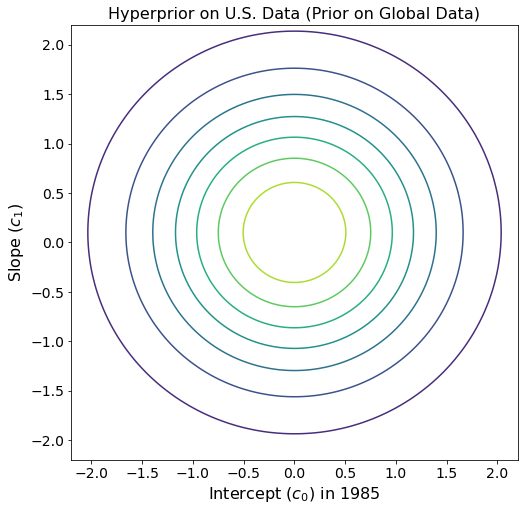

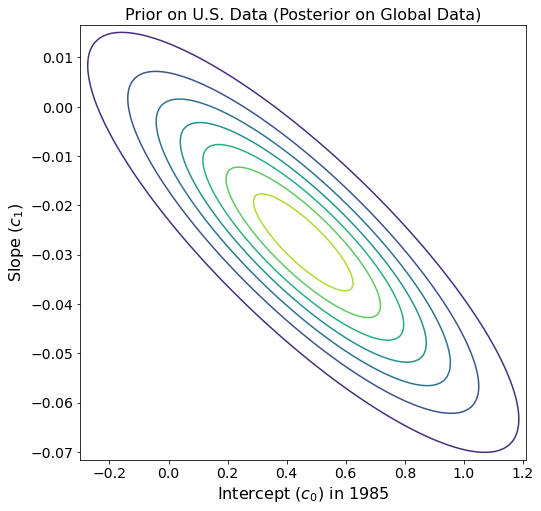

In [4]:
x1_hyperprior = np.linspace(-2.2,2.2,100)
x2_hyperprior = np.linspace(-2.2,2.2,100)
hyperprior_pdf = np.zeros((x1_hyperprior.shape[0], x2_hyperprior.shape[0]))
for i in range(x1_hyperprior.shape[0]):
    for j in range(x2_hyperprior.shape[0]):
       hyperprior_pdf[i,j] = hyperprior.LogDensity([x1_hyperprior[i],x2_hyperprior[j]])
    
prior_mu = prior.GetMean()
prior_cov = prior.GetCovariance()

x1_prior = np.linspace(prior_mu[0]-2.1*np.sqrt(prior_cov[0,0]),prior_mu[0]+2.1*np.sqrt(prior_cov[0,0]),100)
x2_prior = np.linspace(prior_mu[1]-2.1*np.sqrt(prior_cov[1,1]),prior_mu[1]+2.1*np.sqrt(prior_cov[1,1]),100)
prior_pdf = np.zeros((x1_prior.shape[0], x2_prior.shape[0]))
for i in range(x1_prior.shape[0]):
    for j in range(x2_prior.shape[0]):
        prior_pdf[i,j] = prior.LogDensity([x1_prior[i],x2_prior[j]])
        
plt.figure(figsize=(8,8))
plt.contour(x1_hyperprior,x2_hyperprior,np.exp(hyperprior_pdf))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Hyperprior on U.S. Data (Prior on Global Data)',fontsize=16)
plt.xlabel('Intercept ($c_0$) in 1985',fontsize=16)
plt.ylabel('Slope ($c_1$)',fontsize=16)

plt.figure(figsize=(8,8))
plt.contour(x1_prior,x2_prior,np.exp(prior_pdf))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Prior on U.S. Data (Posterior on Global Data)',fontsize=16)
plt.xlabel('Intercept ($c_0$) in 1985',fontsize=16)
plt.ylabel('Slope ($c_1$)',fontsize=16)
plt.show()

## Now, we plot the posterior predictive distribution for the global data (i.e., the prior distribution for the parameters for the U.S.-specific model). 

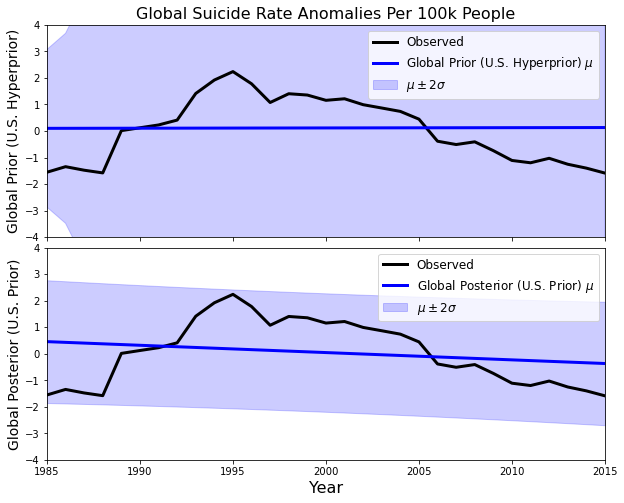

In [5]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(10,8))

US_year_array=np.array([year for year in range(1985,2016)])
axs[1].plot(US_year_array,global_anomalies, 'k', linewidth=3, label='Observed')
axs[0].plot(US_year_array,global_anomalies, 'k', linewidth=3, label='Observed')

pred_years = np.array([year for year in range(1985, 2016)]) - 1985
axs[0].fill_between(pred_years+start_year, hyperprior_pred_mean-2.0*hyperprior_pred_std, hyperprior_pred_mean+2.0*hyperprior_pred_std, color='b', alpha=0.2, label='$\mu\pm2\sigma$')
axs[0].plot(pred_years+start_year,hyperprior_pred_mean, 'b', linewidth=3, label='Global Prior (U.S. Hyperprior) $\mu$')
axs[0].set_ylim([-4,4])

axs[1].fill_between(pred_years+start_year, prior_pred_mean-2.0*prior_pred_std, prior_pred_mean+2.0*prior_pred_std, color='b', alpha=0.2, label='$\mu\pm2\sigma$')
axs[1].plot(pred_years+start_year,prior_pred_mean, 'b', linewidth=3, label='Global Posterior (U.S. Prior) $\mu$')
axs[1].set_ylim([-4,4])

axs[1].set_xlim([pred_years[0]+start_year,pred_years[-1]+start_year])
axs[1].set_ylabel('Global Posterior (U.S. Prior)', fontsize=14)
axs[0].set_ylabel('Global Prior (U.S. Hyperprior)', fontsize=14)
axs[1].set_xlabel('Year', fontsize=16)
axs[0].set_title('Global Suicide Rate Anomalies Per 100k People', fontsize=16)

axs[0].legend(fontsize=12)
axs[1].legend(fontsize=12)
plt.subplots_adjust(wspace=0.01, hspace=0.05)
plt.show()

#### Now, we must get the parameters that we will use as the prior parameters in our U.S. case study. We will also compute the probability that the slope is negative on the global scale, just for further info.

In [6]:
prior_slope_mean = prior.GetMean()[1]
prior_slope_var = prior.GetCovariance()[1,1]

prior_prob = norm.cdf(0.0, loc=prior_slope_mean, scale=np.sqrt(prior_slope_var))
print('Probability that prior slope is negative = %0.3f'%prior_prob)

Probability that prior slope is negative = 0.905


So, we see that the probability that the prior slope is negative is 0.905. We might then assume that there's a 90.5% chance that the slope of the regression line on the global scale of suicides is negative. However, this is not the main question we are asking. We are focused on the U.S., and we now have the parameters for the prior distribution we will use on the U.S. data. Just to reassert what we are doing, we will now define the prior parameters for the U.S. case study that we will now embark on. 

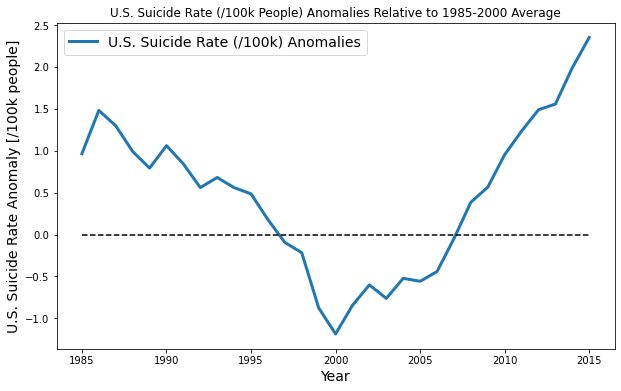

In [7]:
#We essentially re-do the initial analysis, but now for the U.S. specifically
#Read in the full dataset. 
total_df = pd.read_csv('master.csv')
new_df = total_df.iloc[:, 0:6]

#Now, limit our dataset to only those rows with country label 'United States'
new_df = new_df.loc[new_df['country'] == 'United States',:]
year_start = 1985
year_end = 2015 #the U.S. only goes through 2015

#Create an array to store all suicide rates per 100k per year
# across the globe. Run a loop over the array to store each value
# properly. Also, create an array where we can store the average
# from 1985 through 2000. We will then create an anomaly array manually
# afterwawrds for all years from 1985 through 2015.
US_per_100k_array = [0]*(year_end-year_start+1)
rate_1985_2000_100k = np.array([0]*(2000-1985+1))

for year in range(1985, 2016):
    curr_df = new_df.loc[new_df['year'] == year, :]
    suicides_count = sum(curr_df.loc[:, 'suicides_no'])
    population_count = sum(curr_df.loc[:, 'population'])
    if year <= 2000:
        rate_1985_2000_100k[year - 1985] = 100000 * suicides_count / population_count
    rate_per_person = suicides_count/population_count
    rate_per_100k = rate_per_person * 100000
    US_per_100k_array[year - 1985] = rate_per_100k
    
#Calculate the mean number of suicides from 1985 to 2000,
# after which we normalize to a per-100,000 people scale.
# Note that some data are missing (i.e., some countries don't provide
# data for every year), but this is adjusted for since we divide 
# by the total number of disjoint populations in question here.
# (No two rows in the original, full dataset within a given year
# correspond to the same population of people due to the nature
# of the segmentation of this data set.)
US_mean_1985_2000_100k = rate_1985_2000_100k.mean()

#Finally, our array of anomalies:
US_anomalies = np.array([US_per_100k_array - US_mean_1985_2000_100k]).T

#A simple array of years to keep track of when plotting. 
year_array = np.array([[year for year in range(1985, 2016)]]).T

#A plot of our anomalies:
plt.subplots(figsize=(10,6))
plt.plot(year_array, US_anomalies, linewidth=3, label='U.S. Suicide Rate (/100k) Anomalies')
plt.plot([1985,2015],[0,0],'--k')
plt.legend(fontsize=14)
plt.title('U.S. Suicide Rate (/100k People) Anomalies Relative to 1985-2000 Average')
plt.ylabel('U.S. Suicide Rate Anomaly [/100k people]', fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.show()

### Now, we actually perform our Bayesian regression on the U.S. data, using the prior that we generated by examining the posterior over the global data, and finding a new posterior over the U.S. data.

In [8]:
order = 1
obs_var = 0.9**2

#This is the posterior for the global analysis, but the prior
# for the U.S. analysis.
prior = prior

#This is the posterior for the global analysis, but it is the prior
# here since it will be treated as the prior for the U.S. analysis
# that we perform later.
posterior = ConstructPosterior(prior, global_anomalies, obs_var)

#Compute the prior and posterior predictive distributions. 
start_year = 1985
pred_years = np.array([[year for year in range(1985, 2016)]]).T - 1985 

V_pred = CreateVandermonde(order, pred_years)

#Prior predictive distribution (from before)
prior_pred_mean = V_pred@prior.GetMean()
prior_pred_cov = V_pred@prior.ApplyCovariance(V_pred.T) + obs_var*np.eye(pred_years.shape[0])
prior_pred_std = np.sqrt(np.diag(prior_pred_cov))

#Posterior predictive distribution
posterior_pred_mean = V_pred@posterior.GetMean()
posterior_pred_cov = V_pred@posterior.ApplyCovariance(V_pred.T) + obs_var*np.eye(pred_years.shape[0])
posterior_pred_std = np.sqrt(np.diag(posterior_pred_cov))

### Now, we will plot the prior and posterior densities on the U.S. data.

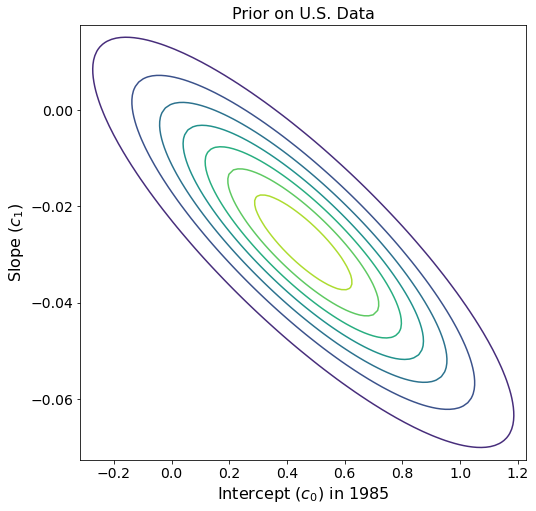

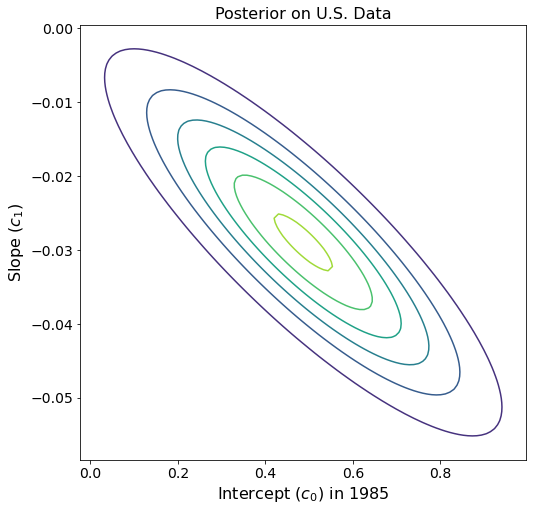

In [9]:
#We have already learned prior_mu and prior_cov from our empirical 
# Bayes' estimation! 
prior_mu = prior.GetMean()
prior_cov = prior.GetCovariance() 
x1_prior = np.linspace(prior_mu[0]-2.15*np.sqrt(prior_cov[0,0]),prior_mu[0]+2.15*np.sqrt(prior_cov[0,0]),100)
x2_prior = np.linspace(prior_mu[1]-2.15*np.sqrt(prior_cov[1,1]),prior_mu[1]+2.15*np.sqrt(prior_cov[1,1]),100)
prior_pdf = np.zeros((x1_prior.shape[0], x2_prior.shape[0]))
for i in range(x1_prior.shape[0]):
    for j in range(x2_prior.shape[0]):
        prior_pdf[i,j] = prior.LogDensity([x1_prior[i],x2_prior[j]])
    
posterior_mu = posterior.GetMean()
posterior_cov = posterior.GetCovariance()

x1_posterior = np.linspace(posterior_mu[0]-2.15*np.sqrt(posterior_cov[0,0]),posterior_mu[0]+2.15*np.sqrt(posterior_cov[0,0]),100)
x2_posterior = np.linspace(posterior_mu[1]-2.15*np.sqrt(posterior_cov[1,1]),posterior_mu[1]+2.15*np.sqrt(posterior_cov[1,1]),100)
posterior_pdf = np.zeros((x1_posterior.shape[0], x2_posterior.shape[0]))
for i in range(x1_posterior.shape[0]):
    for j in range(x2_posterior.shape[0]):
        posterior_pdf[i,j] = posterior.LogDensity([x1_posterior[i],x2_posterior[j]])
        
plt.figure(figsize=(8,8))
plt.contour(x1_prior,x2_prior,np.exp(prior_pdf))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Prior on U.S. Data',fontsize=16)
plt.xlabel('Intercept ($c_0$) in 1985',fontsize=16)
plt.ylabel('Slope ($c_1$)',fontsize=16)

plt.figure(figsize=(8,8))
plt.contour(x1_posterior,x2_posterior,np.exp(posterior_pdf))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Posterior on U.S. Data',fontsize=16)
plt.xlabel('Intercept ($c_0$) in 1985',fontsize=16)
plt.ylabel('Slope ($c_1$)',fontsize=16)
plt.show()

### Finally, we must plot the prior and posterior predictive distributions and ultimately test the probability that the slope of the regression line on our suicide rate anomaly data is negative.

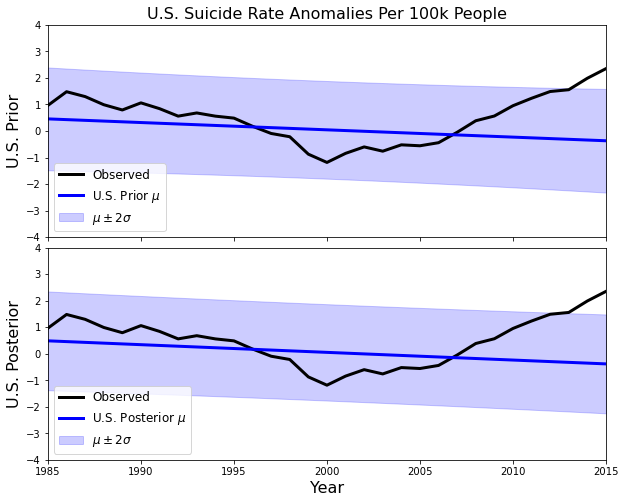

In [10]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(10,8))

US_year_array=np.array([year for year in range(1985,2016)])
axs[1].plot(US_year_array,US_anomalies, 'k', linewidth=3, label='Observed')
axs[0].plot(US_year_array,US_anomalies, 'k', linewidth=3, label='Observed')

pred_years = np.array([year for year in range(1985, 2016)]) - 1985
axs[0].fill_between(pred_years+start_year, prior_pred_mean-2.0*prior_pred_std, prior_pred_mean+2.0*prior_pred_std, color='b', alpha=0.2, label='$\mu\pm2\sigma$')
axs[0].plot(pred_years+start_year,prior_pred_mean, 'b', linewidth=3, label='U.S. Prior $\mu$')
axs[0].set_ylim([-4,4])

axs[1].fill_between(pred_years+start_year, posterior_pred_mean-2.0*posterior_pred_std, posterior_pred_mean+2.0*posterior_pred_std, color='b', alpha=0.2, label='$\mu\pm2\sigma$')
axs[1].plot(pred_years+start_year,posterior_pred_mean, 'b', linewidth=3, label='U.S. Posterior $\mu$')
axs[1].set_ylim([-4,4])

axs[1].set_xlim([pred_years[0]+start_year,pred_years[-1]+start_year])
axs[0].set_ylabel('U.S. Prior', fontsize=16)
axs[1].set_ylabel('U.S. Posterior', fontsize=16)
axs[1].set_xlabel('Year', fontsize=16)
axs[0].set_title('U.S. Suicide Rate Anomalies Per 100k People', fontsize=16)

axs[0].legend(fontsize=12)
axs[1].legend(fontsize=12)
plt.subplots_adjust(wspace=0.01, hspace=0.05)
plt.show()

### We now compute the probability that the slope of the regression line fit to the U.S. data is negative (which would indicate that the suicide rate is, on the whole, decreasing over the past 30 years).

In [11]:
#Extract the slope coefficient's mean and variance.
posterior_slope_mean = posterior.GetMean()[1]
posterior_slope_var = posterior.GetCovariance()[1,1]

posterior_prob = norm.cdf(0.0, loc=posterior_slope_mean, scale=np.sqrt(posterior_slope_var))
print('Probability that posterior slope is negative = %0.3f'%posterior_prob)

Probability that posterior slope is negative = 0.983


So, we see that the probability that the posterior slope is negative is 0.983. We might then assume that there's a 98.3% chance that the slope of the regression line on the U.S. scale of suicides is negative. This is quite conclusive, since it is clear that there is a decreasing suicide rate over the past 30 or so years in the U.S. given this analysis. Clearly, there is a dip in the suicide rate in the U.S. near the year 2000, whereas there is much more of a peak in the suicide rate around 2000 on the global scale. This is a striking disparity, but it nonetheless reflects the same overarching trend of decreasing suicide rates across the globe and across the U.S.

### We finally perform some analysis on the posterior mean and covariance (along with a few probabilities) for the regression coefficients to extract any further insights about our data and overarching question. We discuss these findings in the Discussion section.

In [12]:
#Ascertain the posterior mean vector and covariance matrix
print('Our posterior mean is given by',posterior.GetMean())
print('Our posterior covariance is given by',posterior.GetCovariance())

#Calculate a few illustrative probabilities to be discussed in the
# Discussion section.

posterior_prob1 = norm.cdf(-0.025, loc=posterior_slope_mean, scale=np.sqrt(posterior_slope_var))
print('Probability that posterior slope is less than -0.025 = %0.3f'%posterior_prob1)

posterior_intercept_prob = 1 - norm.cdf(0,loc=posterior.GetMean()[0],scale=np.sqrt(posterior.GetCovariance()[0,0]))
print('Probability that posterior intercept is greater than 0 = %0.3f'%posterior_intercept_prob)

Our posterior mean is given by [ 0.48638365 -0.02898029]
Our posterior covariance is given by [[ 0.05630368 -0.00276889]
 [-0.00276889  0.00018748]]
Probability that posterior slope is less than -0.025 = 0.614
Probability that posterior intercept is greater than 0 = 0.980
